# 项目练习（1）

#### 一、简介

《权力的游戏》大致是根据小说《冰与火之歌》的故事线情节，故事背景设置于虚构的维斯特洛七王国及厄斯索斯大陆。 该系列记录了该领域贵族争夺铁王座的激烈王朝斗争，而其他家庭则为争取独立而斗争。



#### 二、数据集介绍
该数据集包含了三个CSV文件，分别是：battles.csv，character-deaths.csv和character-predictions.csv。现分别介绍如下：

battles.csv：《权利的游戏》中所有的战争。
character-deaths.csv：人物死亡数据集。
character-predictions.csv：人物命运预测数据集。
在每一个CSV数据里面都包含了大量的变量，读懂这些变量名所代表的含义非常有必要。例如：battles.csv中的year变量代表战争发生的时间，battle_type代表战役类型，有伏击战，围攻战，突袭战等。


#### Context

Game of Thrones is a hit fantasy tv show based on the equally famous book series "A Song of Fire and Ice" by George RR Martin. The show is well known for its vastly complicated political landscape, large number of characters, and its frequent character deaths.

#### Content

Of course, it goes without saying that this dataset contains spoilers ;)

This dataset combines three sources of data, all of which are based on information from the book series.

- Firstly, there is battles.csv which contains Chris Albon's "The
War of the Five Kings" Dataset. Its a
great collection of all of the battles in the series.

- Secondly we have character-deaths.csv from Erin Pierce and Ben
Kahle. This dataset was created as a part of their Bayesian Survival
Analysis.

- Finally we have a more comprehensive character dataset with
character-predictions.csv. It
includes their predictions on which character will die.

#### Acknowledgements

- Firstly, there is battles.csv which contains Chris Albon's "The war of the Five Kings" Dataset, which can be found here:

https://github.com/chrisalbon/war_of_the_five_kings_dataset . 

It's a great collection of all of the battles in the series.

- Secondly we have character-deaths.csv from Erin Pierce and BenKahle. This dataset was created as a part of their Bayesian Survival
Analysis which can be found here: http://allendowney.blogspot.com/2015/03/bayesian-survival-analysis-for-game-of.html

- Finally we have a more comprehensive character dataset with character-predictions.csv. This comes from the team at A Song of Ice and Data who scraped it from http://awoiaf.westeros.org/ . It also includes their predictions on which character will die, the methodology of which can be found here: https://got.show/machine-learning-algorithm-predicts-death-game-of-thrones

- Inspiration

What insights about the complicated political landscape of this fantasy world can you find in this data?
  
  
- https://asoiaf.fandom.com/zh/wiki/%E6%97%8F%E8%AF%AD%E5%88%97%E8%A1%A8?variant=zh-hk

## 数据准备

### 导入模块

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
from collections import Counter
import matplotlib.patches as mpatches
plt.style.use('bmh')

### 基础设置

In [2]:
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [12., 8.]
mpl.rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])

pd.set_option('display.max_rows',6)
pd.set_option('display.max_columns',6)
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

### 导入数据

In [3]:
battles = pd.read_csv("./data/battles.csv")
character_deaths = pd.read_csv("./data/character-deaths.csv")
character_predictions = pd.read_csv("./data/character-predictions.csv")

### 新的特征
1. *defender_count* ：防守方的主要家族数量
2. *attacker_count* ：进攻方的主要家族数量
3. *att_comm_count* ：进攻方的指挥者个数
4. *no_of_books* ：一个角色出现在多少本书里

In [4]:
battles.loc[:, "defender_count"] = battles.loc[:,"defender_1":"defender_4"].notnull().sum(axis = 1)
battles.loc[:, "attacker_count"] = battles.loc[:,"attacker_1":"attacker_4"].notnull().sum(axis = 1)
battles.loc[:, "att_comm_count"] = battles['attacker_commander'].str.split(',', expand=True).count(axis=1)   # 缺失值记作0
# battles.loc[:, "att_comm_count"] = [len(x) if isinstance(x,list) else np.nan for x in battles.attacker_commander.str.split(",")]  # 缺失值记作nan
character_predictions.loc[:, "no_of_books"] = character_predictions[[x for x in character_predictions.columns if x.startswith("book")]].sum(axis = 1)

# 数据分析

## 每年的主要角色被杀或者被捕获总数

画出下图

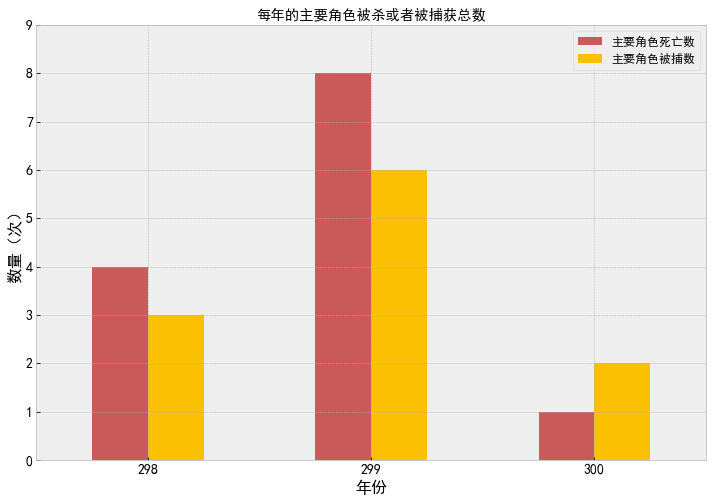

In [5]:
p = battles.groupby('year')[["major_death", "major_capture"]].sum().plot.bar(rot = 0, color = ['#ca5959','#fbc002'])
_ = p.set(xlabel = "年份", ylabel = "数量（次）", title = '每年的主要角色被杀或者被捕获总数', ylim = (0, 9)), p.legend(["主要角色死亡数", "主要角色被捕数"])

### （2）军队规模对于胜利的影响

根据"attacker_size", "defender_size", "attacker_outcome"分析进攻和防守端的规模对于胜利的影响如何？画出下图

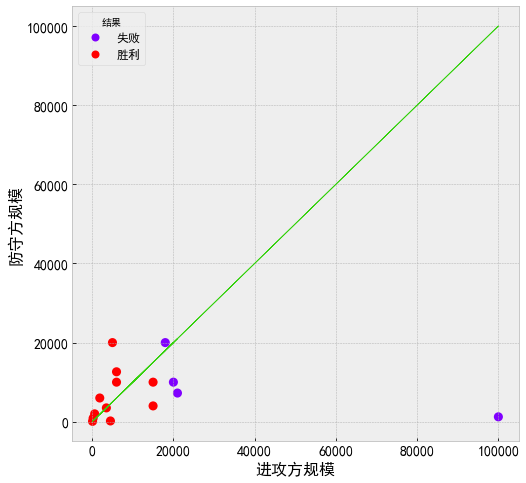

In [6]:
plt.figure(figsize = [8,8])
data = battles.dropna(subset = ["attacker_size", "defender_size", "attacker_outcome"]).copy(deep = True)
scatter = plt.scatter(data["attacker_size"], 
                            data["defender_size"], 
                          #c = data.attacker_outcome.replace({'win':'#da0214','loss':'#35d10e'}), 
                            c = data.attacker_outcome.astype('category').cat.codes,
                            cmap = 'rainbow',
                            s = 50, 
                            lw = 2.)
plt.xlabel('进攻方规模')
plt.ylabel('防守方规模')
plt.legend(handles=scatter.legend_elements()[0], labels=['失败','胜利'],title="结果")
x = data['attacker_size']
plt.plot(x, x, '#34d10c',lw = .8,ls = '-')  # solid green

### （3）不同数量的主要进攻方家族参与的战役数

根据进攻方的主要家族个数，计算对应的战役次数，并画图。

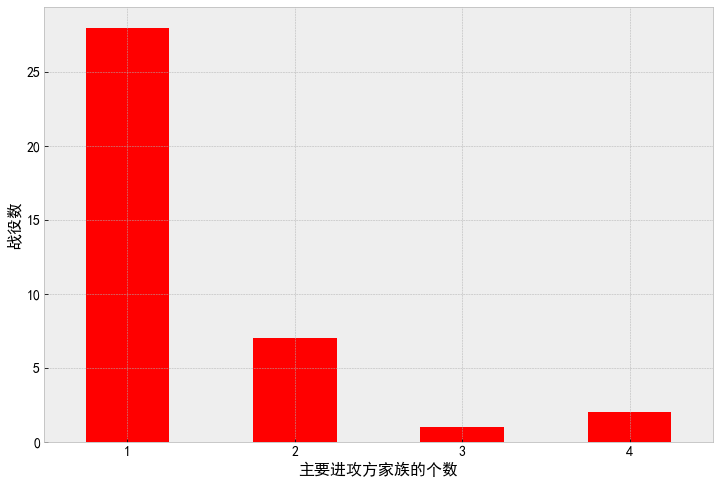

In [7]:
p = battles.attacker_count.value_counts().sort_index().plot.bar(rot = 0, xlabel = "主要进攻方家族的个数", ylabel = "战役数")

### （4）最多次发生战斗的对战方

按照进攻和防守的交手次数的倒序排列，画出下面的图

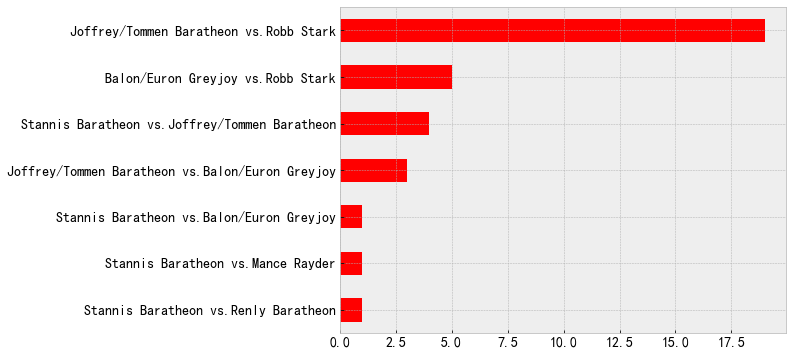

In [8]:
plt.figure(figsize = [8,6])
cnt = pd.Series([tuple(set(x)) for x in battles.dropna(subset = ["attacker_king", "defender_king"])[["attacker_king", "defender_king"]].values if len(set(x)) > 1]).value_counts(ascending=True)
cnt.index = [f"{x[0]} vs.{x[1]}" for x in cnt.index.tolist()]
fig = cnt.plot(kind = 'barh',rot=0)

### （5）不同国王的军队在输和赢的战役中各有多少指挥官？

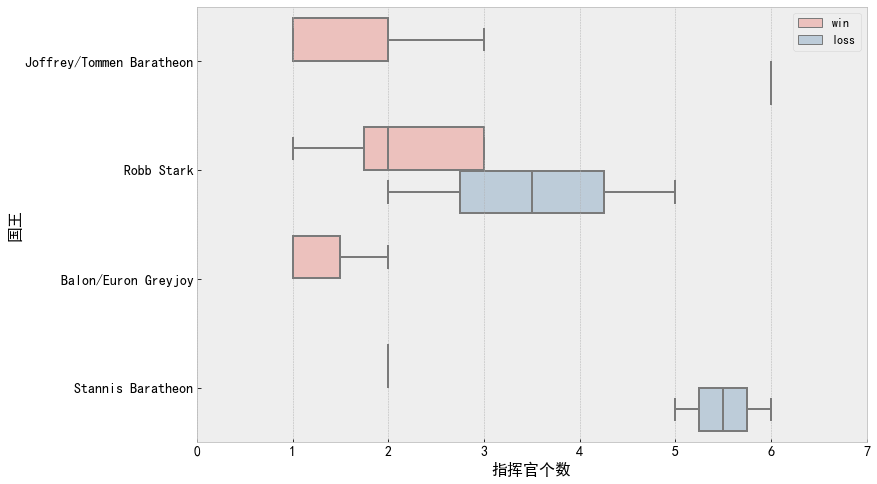

In [9]:
p = sns.boxplot(x = "att_comm_count", y = "attacker_king", data = battles, hue = 'attacker_outcome',saturation = .6, fliersize = 10., palette = 'Pastel1')
_ = p.set(xlabel = "指挥官个数", ylabel = "国王", xticks = range(8))
plt.legend(title = "")

### （6）每个地区发生了多少次重大死亡/俘虏事件？

Text(0, 0.5, '地区')

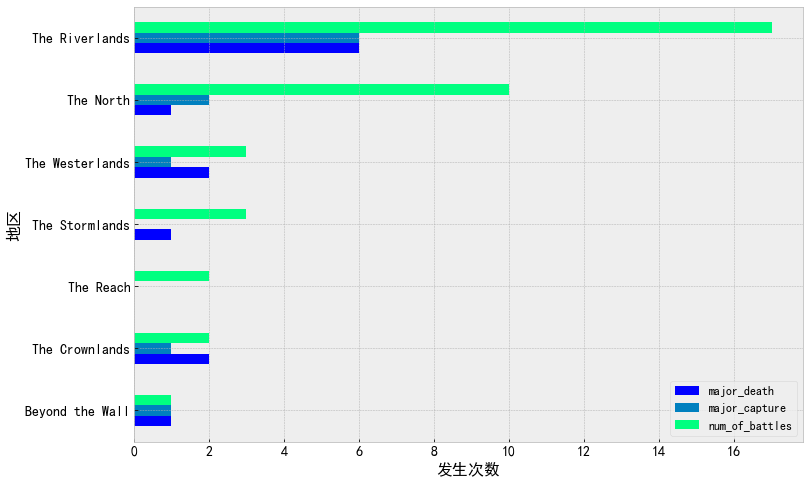

In [10]:
data = battles.groupby("region")[["major_death", "major_capture"]].sum()
data['num_of_battles'] = battles.region.value_counts()
data.sort_values("num_of_battles", ascending = True).copy(deep = True).plot.barh(cmap = 'winter', rot = 0)
plt.xlabel('发生次数')
plt.ylabel('地区')

### （7）存活率和是否和具有死亡关系和出现在第几本书有关？

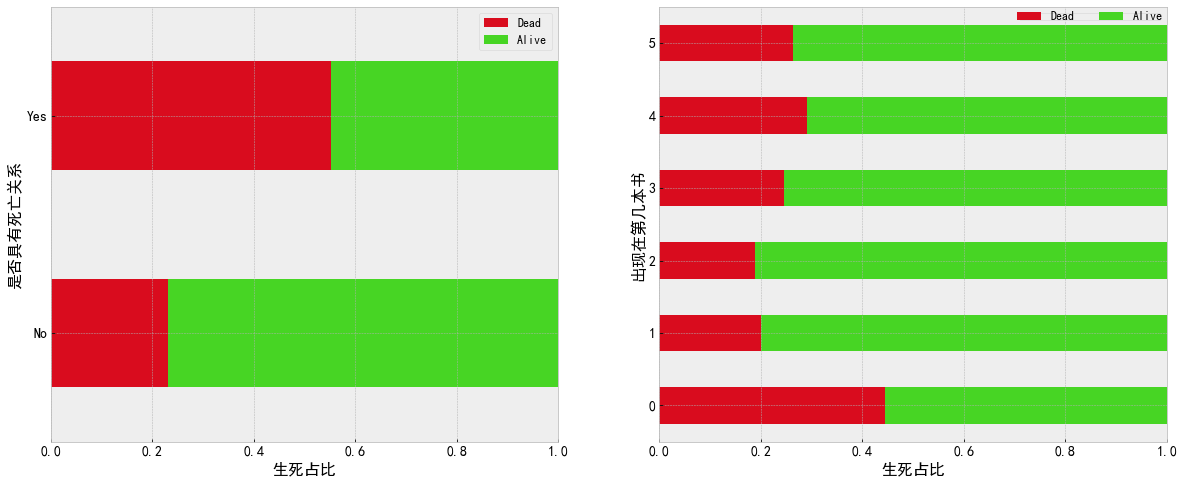

In [11]:
plt.figure(figsize = [20,8])
ax1 = plt.subplot(121)
p = character_predictions.groupby(["boolDeadRelations"])['isAlive'].value_counts(normalize  = True).unstack()\
    .plot.barh(stacked=True,color = ['#d90c1e','#47d524'],ax = ax1)
_ = p.set_xlim([0, 1]), p.set(yticklabels = ["No", "Yes"], xlabel = "生死占比", ylabel = "是否具有死亡关系"), p.legend(["Dead", "Alive"])

ax2 = plt.subplot(122)
p = character_predictions.groupby(["no_of_books"])['isAlive'].value_counts(normalize  = True).unstack()\
    .plot.barh(stacked=True,color = ['#d90c1e','#47d524'],ax = ax2)
_ = p.set(xlim = [0, 1], ylabel = "出现在第几本书", xlabel = "生死占比"), p.legend(["Dead", "Alive"], loc = "upper right", ncol = 2, borderpad = -.15)

### （8）军队规模大就一定赢么？

计算每个战役的攻守方人数差异，胜利则赋予红色，失败则赋予绿色。

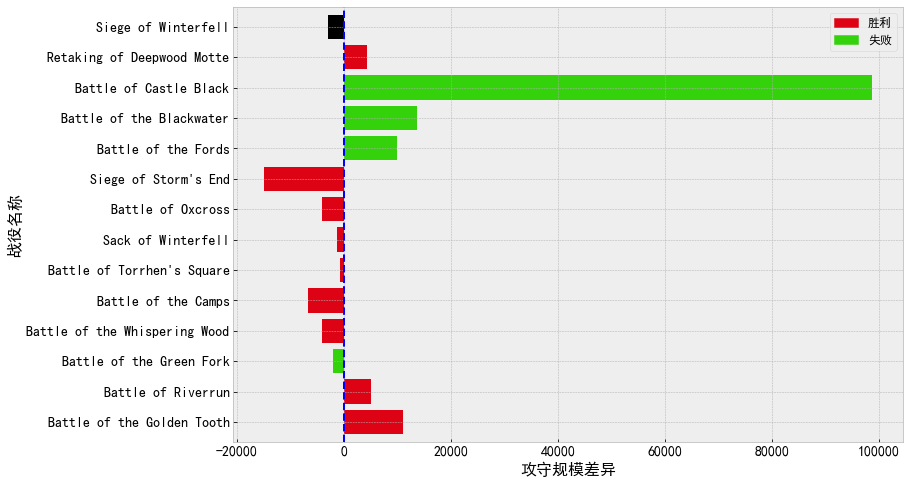

In [12]:
data = battles.dropna(subset = ["attacker_size", "defender_size"]).copy(deep = True)
data = pd.concat([(data.attacker_size - data.defender_size).to_frame(name = 'size_diff'), battles[["attacker_outcome"]]], axis = 1, join = "inner")
data = data[data['size_diff'] != 0]
p = data['size_diff'].plot.barh(figsize = (12, 8), width = .8, color = ['#de0215' if x == "win" else '#33d20b' if x == "loss" else "black" for x in data.attacker_outcome.values])
_ = p.legend(handles = [mpatches.Patch(color = '#de0215', label = "胜利", aa = True), mpatches.Patch(color = '#33d20b', label = "失败", aa = True)])
_ = p.axvline(0, color = 'Blue', ls = '--'), p.set(yticklabels = battles.name.iloc[data.index].values, xlabel = "攻守规模差异", ylabel = "战役名称")